## Imports

In [1]:
# For this practical example we will need the following libraries and modules
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

### Palette

THEME


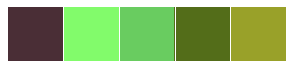

In [2]:
#Lets set the style of all our seaborn based plots
plt.style.use(['ggplot'])
# Setting the theme of our plots
theme = ["#4a2e36", "#82fB6B","#69cc60","#536d19","#99a129"]
print('THEME')
sns.palplot(sns.color_palette(theme))
palette= sns.set_palette(sns.color_palette(theme))

****
### Load dataset and preprocess

In [3]:
# Load the data from a .csv in the same folder
data = pd.read_csv('drug200.csv')

# Let's explore the top 5 rows of the df
data.head().style.background_gradient(cmap='Greens',axis=None)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355000,DrugY
1,47,M,LOW,HIGH,13.093000,drugC
2,47,M,LOW,HIGH,10.114000,drugC
3,28,F,NORMAL,HIGH,7.798000,drugX
4,61,F,LOW,HIGH,18.043000,DrugY


In [4]:
# check for numeric data
data.describe().T.style.background_gradient(cmap='Greens',axis=None)

,count,mean,std,min,25%,50%,75%,max
Age,200.000000,44.315000,16.544315,15.000000,31.000000,45.000000,58.000000,74.000000
Na_to_K,200.000000,16.084485,7.223956,6.269000,10.445500,13.936500,19.380000,38.247000


Already looks like a normal distribution data

In [5]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,200.0,NaN,NaN,NaN,44.315,16.544315,15.0,31.0,45.0,58.0,74.0
Sex,200,2,M,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BP,200,3,HIGH,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cholesterol,200,2,HIGH,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Na_to_K,200.0,NaN,NaN,NaN,16.084485,7.223956,6.269,10.4455,13.9365,19.38,38.247
Drug,200,5,DrugY,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* We can also see there is no missing data in our dataset.
* We can also see we do not have too many unique names for the objects data.

**We do see that the most frequent drug is DrugY, and we will make sure we do not have biased data.**

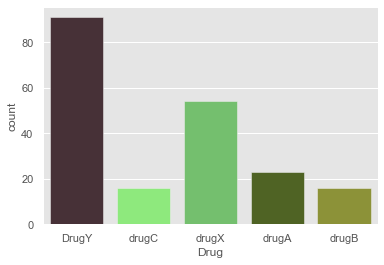

In [6]:
sns.countplot(data['Drug'])

As suspected, there is a bit of imbalanced data, but not something very siginificant:<br>
91 VS ~18, but we do have 5 drug types.<br>
Therefore, we won't treat this as imbalanced data.

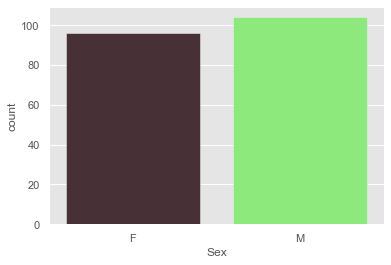

In [7]:
sns.countplot(data['Sex'])

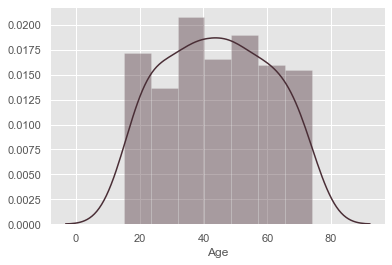

In [8]:
sns.distplot(data['Age'])

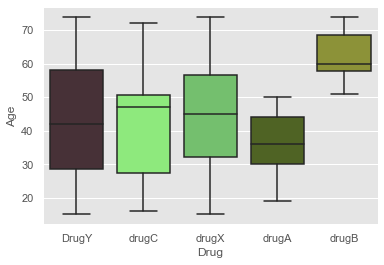

In [9]:
sns.boxplot(x=data['Drug'],y=data['Age'])

Looks like we also can see that DrugB is significaltly relevant only to the elderly aged, mostly above 60 yo.

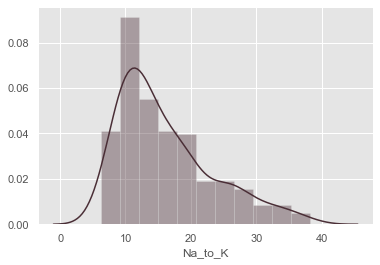

In [10]:
sns.distplot(data['Na_to_K'])

We have here right skew data in column **Na_to_K**.

***
## Feature engineering


In [11]:
data_temp = data.copy()

In [12]:
data_temp['Drug']=data_temp['Drug'].map({'drugA':0,'drugB':1,'drugC':2,'drugX':3,'DrugY':4})

In [13]:
data_with_dummies = pd.get_dummies(data_temp, drop_first=True)

In [14]:
data_with_dummies.head()

,Age,Na_to_K,Drug,Sex_M,BP_LOW,BP_NORMAL,Cholesterol_NORMAL
0,23,25.355,4,0,0,0,0
1,47,13.093,2,1,1,0,0
2,47,10.114,2,1,1,0,0
3,28,7.798,3,0,0,1,0
4,61,18.043,4,0,1,0,0


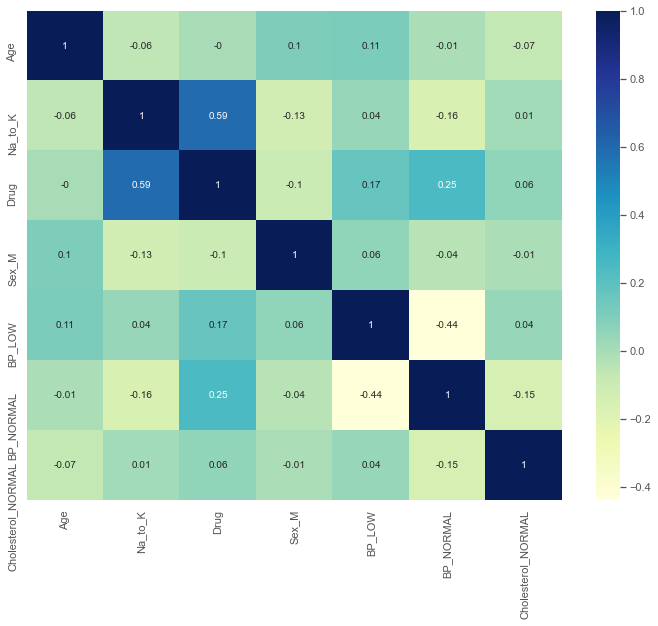

In [15]:
plt.figure(figsize=(12, 9));
correlation_matrix = data_with_dummies.corr().round(2);
sns.heatmap(correlation_matrix, cmap="YlGnBu", annot=True);

We can see high correlation between drug and Na_to_K

#### Let's check also VIF

In [16]:
# Function to calculate VIF
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data_with_dummies.columns
    for i in range(0, x_var_names.shape[0]):
        y = data_with_dummies[x_var_names[i]]
        x = data_with_dummies[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

X=data_with_dummies.drop(['Drug'],axis=1)
calculate_vif(X)

,Var,Vif
2,Drug,13.12
1,Na_to_K,9.83
0,Age,5.17
5,BP_NORMAL,2.57
4,BP_LOW,2.30
3,Sex_M,2.01
6,Cholesterol_NORMAL,1.86


#### Secondary Method

In [17]:
variables = data_with_dummies.columns
variables

Index(['Age', 'Na_to_K', 'Drug', 'Sex_M', 'BP_LOW', 'BP_NORMAL',
       'Cholesterol_NORMAL'],
      dtype='object')

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data_with_dummies[['Age', 'Na_to_K', 'Sex_M', 'BP_LOW', 'BP_NORMAL','Cholesterol_NORMAL']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
vif.sort_values(by = 'VIF', axis = 0, ascending=False, inplace=False)

,VIF,Features
0,5.170173,Age
1,3.827717,Na_to_K
2,2.003538,Sex_M
5,1.805006,Cholesterol_NORMAL
3,1.797654,BP_LOW
4,1.619725,BP_NORMAL


Once we removed the Drug "feature" we can see the results were better of course.

***
### Declare the inputs and the targets

In [19]:
data_preprocessed = data_with_dummies
data_preprocessed.head(2)

,Age,Na_to_K,Drug,Sex_M,BP_LOW,BP_NORMAL,Cholesterol_NORMAL
0,23,25.355,4,0,0,0,0
1,47,13.093,2,1,1,0,0


In [20]:
# The target(s) (dependent variable) is 'log price'
targets = data_preprocessed['Drug']

# The inputs are everything BUT the dependent variable, so we can simply drop it
inputs = data_preprocessed.drop(['Drug'],axis=1)


#### Check for highly correlated features

In [21]:
columns = np.full((inputs.corr().shape[0],), True, dtype=bool)
for i in range(inputs.corr().shape[0]):
    for j in range(i+1, inputs.corr().shape[0]):
        if inputs.corr().iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = inputs.columns[columns]
inputs = inputs[selected_columns]

In [22]:
inputs.columns.values

array(['Age', 'Na_to_K', 'Sex_M', 'BP_LOW', 'BP_NORMAL',
       'Cholesterol_NORMAL'], dtype=object)

**No highly correlated features which needs to be removed**

#### Check for VarianceThreshold

In [23]:
from sklearn.feature_selection import VarianceThreshold

In [24]:
treshhold = VarianceThreshold(threshold=0)

In [25]:
treshhold.fit(inputs)

VarianceThreshold(threshold=0)

In [26]:
treshhold.get_support()

array([ True,  True,  True,  True,  True,  True])

#### Another check using featurewiz

In [27]:
# !pip install featurewiz

In [28]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from featurewiz import featurewiz

Imported featurewiz. Version = 0.1.32. Now with dask, XGBoost-GPU and feather-format.
outputs = featurewiz(dataname, target, corr_limit=0.70, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (200, 7)
    Loaded train data. Shape = (200, 7)
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set.

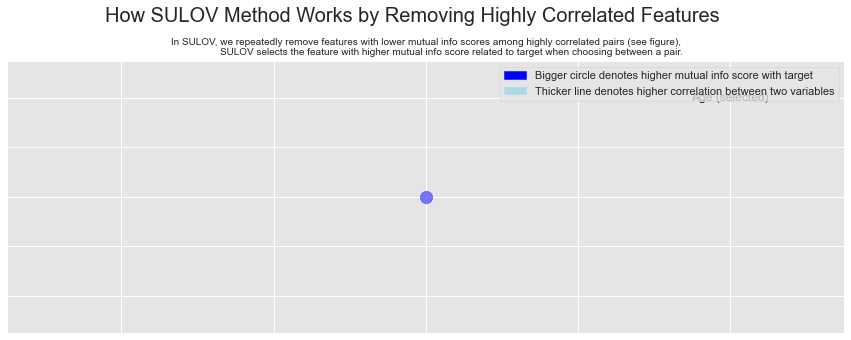

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 6
Final list of selected vars after SULOV = 6
Readying dataset for Recursive XGBoost by converting all features to numeric...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Current number of predictors = 6 
    XGBoost version: 1.6.0
Number of booster rounds = 100
        using 6 variables...
Regular XGBoost is crashing due to: dlsym(0x213773b20, XGDMatrixCreateFromDense): symbol not found
dlsym(0x213773b20, XGDMatrixCreateFromDense): symbol not found
Regular XGBoost is crashing due to local variable 'dtrain' referenced before assignment. Returning with curr

In [29]:
out1, out2 = featurewiz(data_with_dummies, 'Drug', corr_limit=0.7, verbose=0)

In [30]:
out2.head()

,Na_to_K,Sex_M,BP_LOW,BP_NORMAL,Cholesterol_NORMAL,Age,Drug
0,25.355,0,0,0,0,23,4
1,13.093,1,1,0,0,47,2
2,10.114,1,1,0,0,47,2
3,7.798,0,0,1,0,28,3
4,18.043,0,1,0,0,61,4


**From all the checks we have created, we can use all 6 features for our model**

In [31]:
print(f'''
inputs:
{inputs.head(2)}
----------------------
Targets: 
{targets.head(4)}
''')


inputs:
   Age  Na_to_K  Sex_M  BP_LOW  BP_NORMAL  Cholesterol_NORMAL
0   23   25.355      0       0          0                   0
1   47   13.093      1       1          0                   0
----------------------
Targets: 
0    4
1    2
2    2
3    3
Name: Drug, dtype: int64



## Splitting the dataset into the Training set and Test set

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.25, random_state = 0)

### Logistic regression

In [33]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [34]:
# predictions
y_pred = classifier.predict(X_test)
X_test
print(classifier.predict([[79,10.67,0,1,1,0]]))

[3]


In [35]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, multilabel_confusion_matrix
y_unique = y_test.unique()
cm = multilabel_confusion_matrix(y_test, y_pred, labels = y_unique)
print(cm)
accuracy_score(y_test, y_pred)

[[[47  0]
  [ 1  2]]

 [[32  2]
  [ 2 14]]

 [[21  4]
  [ 3 22]]

 [[44  1]
  [ 2  3]]

 [[47  2]
  [ 1  0]]]


0.82

***
### KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [37]:
y_pred = classifier.predict(X_test)

In [38]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, multilabel_confusion_matrix
y_unique = y_test.unique()
cm = multilabel_confusion_matrix(y_test, y_pred, labels = y_unique)
print(cm)
accuracy_score(y_test, y_pred)

[[[46  1]
  [ 3  0]]

 [[31  3]
  [10  6]]

 [[25  0]
  [ 2 23]]

 [[38  7]
  [ 0  5]]

 [[45  4]
  [ 0  1]]]


0.7

***
### SVM

In [39]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [40]:
y_pred = classifier.predict(X_test)

In [41]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, multilabel_confusion_matrix
y_unique = y_test.unique()
cm = multilabel_confusion_matrix(y_test, y_pred, labels = y_unique)
print(cm)
accuracy_score(y_test, y_pred)

[[[47  0]
  [ 3  0]]

 [[26  8]
  [ 0 16]]

 [[24  1]
  [ 0 25]]

 [[45  0]
  [ 5  0]]

 [[49  0]
  [ 1  0]]]


0.82

***
### Naive bayes

In [42]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [43]:
y_pred = classifier.predict(X_test)

In [44]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, multilabel_confusion_matrix
y_unique = y_test.unique()
cm = multilabel_confusion_matrix(y_test, y_pred, labels = y_unique)
print(cm)
accuracy_score(y_test, y_pred)

[[[44  3]
  [ 0  3]]

 [[33  1]
  [ 2 14]]

 [[23  2]
  [ 9 16]]

 [[42  3]
  [ 0  5]]

 [[47  2]
  [ 0  1]]]


0.78

***
### Decision Tree

In [45]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [46]:
y_pred = classifier.predict(X_test)

In [47]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, multilabel_confusion_matrix
y_unique = y_test.unique()
cm = multilabel_confusion_matrix(y_test, y_pred, labels = y_unique)
print(cm)
accuracy_score(y_test, y_pred)

[[[47  0]
  [ 0  3]]

 [[34  0]
  [ 0 16]]

 [[25  0]
  [ 0 25]]

 [[45  0]
  [ 0  5]]

 [[49  0]
  [ 0  1]]]


1.0

Seems like we have an overfitting model here which is not recommanded.

***
### Random Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 5, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=5, random_state=0)

In [49]:
y_pred = classifier.predict(X_test)

In [50]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, multilabel_confusion_matrix
y_unique = y_test.unique()
cm = multilabel_confusion_matrix(y_test, y_pred, labels = y_unique)
print(cm)
accuracy_score(y_test, y_pred)

[[[47  0]
  [ 0  3]]

 [[34  0]
  [ 0 16]]

 [[25  0]
  [ 0 25]]

 [[45  0]
  [ 0  5]]

 [[49  0]
  [ 0  1]]]


1.0

Seems like we have an overfitting model here which is not recommanded.

***